# Lab 05: SHAP Deep Dive

## A Comprehensive Guide to SHAP Explanations

---

## Learning Objectives

By the end of this lab, you will be able to:

1. **Understand** the mathematical foundation of SHAP (Shapley values)
2. **Apply** SHAP to both **regression** and **classification** problems
3. **Distinguish** between **local** (single prediction) and **global** (model-level) explanations
4. **Create** all major SHAP visualization types
5. **Interpret** SHAP plots correctly
6. **Choose** the right SHAP explainer for your model

---

## What is SHAP?

**SHAP (SHapley Additive exPlanations)** is a unified approach to explain the output of any machine learning model. It connects game theory with local explanations.

### Key Concepts

**Shapley Values (from Game Theory):**
- Imagine features as "players" in a game
- The "payout" is the model's prediction
- **Question:** How much did each player (feature) contribute to the payout?

**SHAP Properties:**
1. **Local accuracy:** SHAP values sum to the difference between prediction and expected value
2. **Missingness:** Features with no impact have SHAP value of 0
3. **Consistency:** If a model changes so a feature has a larger impact, its SHAP value increases

---

## Part 1: Setup and Imports

In [1]:
# Install SHAP if needed
# !pip install shap

# Core imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.datasets import load_diabetes, load_breast_cancer, fetch_california_housing
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score

# SHAP
import shap

# Initialize JavaScript for SHAP plots in notebooks
shap.initjs()

# Settings
np.random.seed(42)
plt.rcParams['figure.figsize'] = (12, 6)
sns.set_style('whitegrid')

print(f"SHAP version: {shap.__version__}")
print("✓ All libraries loaded successfully!")

/Users/sschacht/anaconda3/envs/dspy/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


SHAP version: 0.49.1
✓ All libraries loaded successfully!


---

## Part 2: Understanding SHAP Values - The Math

### Shapley Value Formula

The Shapley value for feature $i$ is:

$$\phi_i = \sum_{S \subseteq N \setminus \{i\}} \frac{|S|! (|N| - |S| - 1)!}{|N|!} [f(S \cup \{i\}) - f(S)]$$

**In words:**
- Consider all possible subsets of features (without feature $i$)
- For each subset, calculate how much adding feature $i$ changes the prediction
- Average this across all subsets, weighted by subset size

### Simple Example

Imagine predicting house price with 2 features: **size** and **location**.

| Features Used | Prediction |
|--------------|------------|
| None (baseline) | $300,000 |
| Size only | $350,000 |
| Location only | $320,000 |
| Both | $400,000 |

**Shapley value for Size:**
- Contribution when added first: $350,000 - $300,000 = $50,000
- Contribution when added second: $400,000 - $320,000 = $80,000
- Average: ($50,000 + $80,000) / 2 = **$65,000**

**Shapley value for Location:**
- Contribution when added first: $320,000 - $300,000 = $20,000
- Contribution when added second: $400,000 - $350,000 = $50,000
- Average: ($20,000 + $50,000) / 2 = **$35,000**

**Check:** $65,000 + $35,000 = $100,000 = $400,000 - $300,000 ✓

---

### Demonstrating SHAP Calculation

In [2]:
# Simple demonstration of Shapley value calculation
# Using the house price example above

def manual_shapley_demo():
    """
    Manually calculate Shapley values for 2-feature example
    """
    # Predictions for all feature combinations
    f_empty = 300000  # No features (baseline)
    f_size = 350000   # Size only
    f_loc = 320000    # Location only
    f_both = 400000   # Both features
    
    # Shapley value for Size
    # Marginal contribution when added first (to empty set)
    mc_size_first = f_size - f_empty
    # Marginal contribution when added second (to {location})
    mc_size_second = f_both - f_loc
    # Average
    shapley_size = (mc_size_first + mc_size_second) / 2
    
    # Shapley value for Location
    mc_loc_first = f_loc - f_empty
    mc_loc_second = f_both - f_size
    shapley_loc = (mc_loc_first + mc_loc_second) / 2
    
    print("=== Manual Shapley Value Calculation ===")
    print(f"\nBaseline (no features): ${f_empty:,}")
    print(f"Final prediction (all features): ${f_both:,}")
    print(f"Difference to explain: ${f_both - f_empty:,}")
    print(f"\n--- Size Feature ---")
    print(f"  Added first: ${mc_size_first:,}")
    print(f"  Added second: ${mc_size_second:,}")
    print(f"  Shapley value: ${shapley_size:,.0f}")
    print(f"\n--- Location Feature ---")
    print(f"  Added first: ${mc_loc_first:,}")
    print(f"  Added second: ${mc_loc_second:,}")
    print(f"  Shapley value: ${shapley_loc:,.0f}")
    print(f"\n--- Verification ---")
    print(f"Sum of Shapley values: ${shapley_size + shapley_loc:,.0f}")
    print(f"Prediction - Baseline: ${f_both - f_empty:,}")
    print(f"Match: {abs((shapley_size + shapley_loc) - (f_both - f_empty)) < 1} ✓")
    
manual_shapley_demo()

=== Manual Shapley Value Calculation ===

Baseline (no features): $300,000
Final prediction (all features): $400,000
Difference to explain: $100,000

--- Size Feature ---
  Added first: $50,000
  Added second: $80,000
  Shapley value: $65,000

--- Location Feature ---
  Added first: $20,000
  Added second: $50,000
  Shapley value: $35,000

--- Verification ---
Sum of Shapley values: $100,000
Prediction - Baseline: $100,000
Match: True ✓


### Why Shapley Values?

**Shapley values are the ONLY attribution method that satisfies:**

1. **Efficiency:** Attributions sum to the total payout (prediction - baseline)
2. **Symmetry:** Features with same contribution get same attribution
3. **Dummy:** Features with zero contribution get zero attribution
4. **Additivity:** For combined models, attributions add up

**This makes SHAP theoretically superior to alternatives like LIME!**

---

---

# SECTION A: SHAP for Regression

---

## Part 3: Regression Example - California Housing

We'll predict house prices in California using multiple features.

### 3.1 Load and Prepare Data

In [3]:
# Load California Housing dataset
housing = fetch_california_housing()
X_housing = pd.DataFrame(housing.data, columns=housing.feature_names)
y_housing = housing.target  # Median house value (in $100,000s)

print("=== California Housing Dataset ===")
print(f"Samples: {len(X_housing)}")
print(f"Features: {len(X_housing.columns)}")
print(f"\nFeature descriptions:")
print("- MedInc: Median income in block group")
print("- HouseAge: Median house age in block group")
print("- AveRooms: Average number of rooms per household")
print("- AveBedrms: Average number of bedrooms per household")
print("- Population: Block group population")
print("- AveOccup: Average number of household members")
print("- Latitude: Block group latitude")
print("- Longitude: Block group longitude")
print(f"\nTarget: Median house value (in $100,000s)")
print(f"Target range: ${y_housing.min()*100000:,.0f} - ${y_housing.max()*100000:,.0f}")

=== California Housing Dataset ===
Samples: 20640
Features: 8

Feature descriptions:
- MedInc: Median income in block group
- HouseAge: Median house age in block group
- AveRooms: Average number of rooms per household
- AveBedrms: Average number of bedrooms per household
- Population: Block group population
- AveOccup: Average number of household members
- Latitude: Block group latitude
- Longitude: Block group longitude

Target: Median house value (in $100,000s)
Target range: $14,999 - $500,001


In [4]:
# Quick EDA
X_housing.describe().round(2)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,20640.00,20640.00,20640.00,20640.00,20640.00,20640.00,20640.00,20640.00
mean,3.87,28.64,5.43,1.10,1425.48,3.07,35.63,-119.57
std,1.90,12.59,2.47,0.47,1132.46,10.39,2.14,2.00
min,0.50,1.00,0.85,0.33,3.00,0.69,32.54,-124.35
25%,2.56,18.00,4.44,1.01,787.00,2.43,33.93,-121.80
50%,3.53,29.00,5.23,1.05,1166.00,2.82,34.26,-118.49
75%,4.74,37.00,6.05,1.10,1725.00,3.28,37.71,-118.01
max,15.00,52.00,141.91,34.07,35682.00,1243.33,41.95,-114.31


In [5]:
# Train-test split
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_housing, y_housing, test_size=0.2, random_state=42
)

print(f"Training samples: {len(X_train_reg)}")
print(f"Test samples: {len(X_test_reg)}")

Training samples: 16512
Test samples: 4128


### 3.2 Train Regression Model

In [6]:
# Train a Random Forest Regressor
reg_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

reg_model.fit(X_train_reg, y_train_reg)

# Evaluate
y_pred_reg = reg_model.predict(X_test_reg)
rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))
r2 = r2_score(y_test_reg, y_pred_reg)

print("=== Regression Model Performance ===")
print(f"Model: Random Forest Regressor")
print(f"RMSE: ${rmse * 100000:,.0f}")
print(f"R² Score: {r2:.3f}")
print("\n✓ Model trained successfully!")

=== Regression Model Performance ===
Model: Random Forest Regressor
RMSE: $54,449
R² Score: 0.774

✓ Model trained successfully!


### 3.3 Create SHAP Explainer for Regression

**SHAP Explainer Types:**

| Explainer | Best For | Speed |
|-----------|----------|-------|
| `TreeExplainer` | Tree-based models (RF, XGBoost, LightGBM) | Fast |
| `LinearExplainer` | Linear models (Linear/Logistic Regression) | Fast |
| `DeepExplainer` | Deep learning models | Medium |
| `KernelExplainer` | Any model (model-agnostic) | Slow |
| `Explainer` | Auto-selects best explainer | Varies |

For Random Forest, we use **TreeExplainer** (fastest and most accurate).

In [ ]:
# Create SHAP explainer for tree-based model
explainer_reg = shap.TreeExplainer(reg_model)

# Calculate SHAP values for test set (use subset for speed)
# For larger datasets, use a sample
X_test_sample_reg = X_test_reg.iloc[:500]  # First 500 samples

print("Calculating SHAP values for regression model...")
shap_values_reg = explainer_reg.shap_values(X_test_sample_reg)

print(f"\n✓ SHAP values calculated!")
print(f"Shape of SHAP values: {shap_values_reg.shape}")
print(f"(samples, features)")

# Handle expected_value format for both scalar and array cases
expected_value = explainer_reg.expected_value

print(f"\nExpected value (baseline): {expected_value[0] * 100000:,.0f}")

Calculating SHAP values for regression model...

✓ SHAP values calculated!
Shape of SHAP values: (500, 8)
(samples, features)

Expected value (baseline): 207,307


In [ ]:
# Per Dataset Contribution
shap_values_reg[0]

array([-0.86645723,  0.00648761, -0.00436218, -0.00590228, -0.00322682,
       -0.23445495, -0.22245779, -0.17466353])

---

## Part 4: Local Explanations for Regression

**Local explanations** explain a single prediction.

**Question:** Why did the model predict THIS specific value for THIS specific house?

---

### 4.1 Force Plot (Single Prediction)

The **force plot** shows how each feature pushes the prediction from the base value (average) to the final prediction.

In [ ]:
# Select a single sample to explain
sample_idx = 0

# Get prediction for this sample (use DataFrame slice to preserve feature names)
sample = X_test_sample_reg.iloc[sample_idx]  # Series for display
sample_df = X_test_sample_reg.iloc[[sample_idx]]  # DataFrame for prediction
prediction = reg_model.predict(sample_df)[0]

# Fix: y_test_reg is a NumPy array, so use standard indexing, not .iloc
actual = y_test_reg[sample_idx]

print(f"=== Sample {sample_idx} ===")
print(f"\nFeature values:")
for feat, val in sample.items():
    print(f"  {feat}: {val:.2f}")
print(f"\nActual price: ${actual * 100000:,.0f}")
print(f"Predicted price: ${prediction * 100000:,.0f}")


# Fix: explainer_reg.expected_value might be an array (e.g., shape = (1,))
# To ensure formatting works, use explainer_reg.expected_value[0]
base_value = explainer_reg.expected_value[0] if hasattr(explainer_reg.expected_value, "__len__") and not isinstance(explainer_reg.expected_value, str) else explainer_reg.expected_value
print(f"Base value (avg): ${base_value * 100000:,.0f}")

=== Sample 0 ===

Feature values:
  MedInc: 1.68
  HouseAge: 25.00
  AveRooms: 4.19
  AveBedrms: 1.02
  Population: 1392.00
  AveOccup: 3.88
  Latitude: 36.06
  Longitude: -119.01

Actual price: $47,700
Predicted price: $56,803
Base value (avg): $207,307


/Users/sschacht/anaconda3/envs/dspy/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [21]:
# Show SHAP values as monetary contributions
print(f"\n=== SHAP Monetary Contributions for Sample {sample_idx} ===\n")

shap_vals = shap_values_reg[sample_idx]
feature_names = X_test_sample_reg.columns.tolist()

print(f"{'Feature':<12} {'Value':>10} {'SHAP Value':>12} {'$ Contribution':>15}")
print("-" * 52)

for feat, val, shap_val in zip(feature_names, sample.values, shap_vals):
    dollar_contribution = shap_val * 100000
    direction = "↑" if shap_val > 0 else "↓"
    print(f"{feat:<12} {val:>10.2f} {shap_val:>12.4f} {direction} ${abs(dollar_contribution):>12,.0f}")

print("-" * 52)
print(f"{'TOTAL':<12} {'':<10} {shap_vals.sum():>12.4f}    ${shap_vals.sum() * 100000:>12,.0f}")
print(f"\nBase value:     ${base_value * 100000:>12,.0f}")
print(f"+ SHAP sum:     ${shap_vals.sum() * 100000:>12,.0f}")
print(f"= Prediction:   ${prediction * 100000:>12,.0f}")


=== SHAP Monetary Contributions for Sample 0 ===

Feature           Value   SHAP Value  $ Contribution
----------------------------------------------------
MedInc             1.68      -0.8665 ↓ $      86,646
HouseAge          25.00       0.0065 ↑ $         649
AveRooms           4.19      -0.0044 ↓ $         436
AveBedrms          1.02      -0.0059 ↓ $         590
Population      1392.00      -0.0032 ↓ $         323
AveOccup           3.88      -0.2345 ↓ $      23,445
Latitude          36.06      -0.2225 ↓ $      22,246
Longitude       -119.01      -0.1747 ↓ $      17,466
----------------------------------------------------
TOTAL                        -1.5050    $    -150,504

Base value:     $     207,307
+ SHAP sum:     $    -150,504
= Prediction:   $      56,803


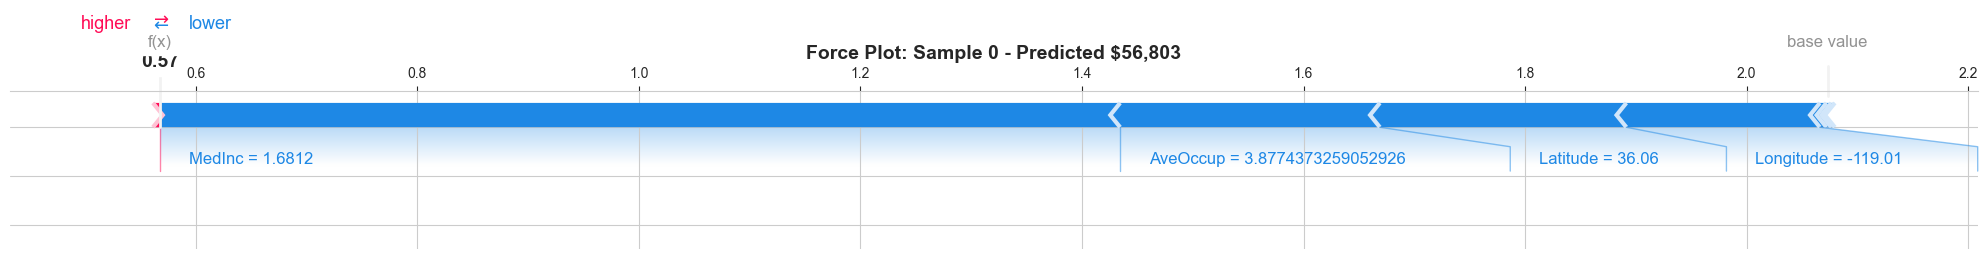


Interpretation:
- Base value (gray): Average prediction across all samples
- Red features: Push prediction HIGHER
- Blue features: Push prediction LOWER
- Arrow length: Magnitude of contribution
- Final value: Where arrows end = prediction


In [22]:
# Force plot for single prediction
shap.force_plot(
    base_value=explainer_reg.expected_value,
    shap_values=shap_values_reg[sample_idx],
    features=X_test_sample_reg.iloc[sample_idx],
    matplotlib=True,
    show=False
)
plt.title(f'Force Plot: Sample {sample_idx} - Predicted ${prediction * 100000:,.0f}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("- Base value (gray): Average prediction across all samples")
print("- Red features: Push prediction HIGHER")
print("- Blue features: Push prediction LOWER")
print("- Arrow length: Magnitude of contribution")
print("- Final value: Where arrows end = prediction")

### 4.2 Waterfall Plot (Single Prediction)

The **waterfall plot** shows the same information as force plot, but in a vertical, step-by-step format. Often easier to read!

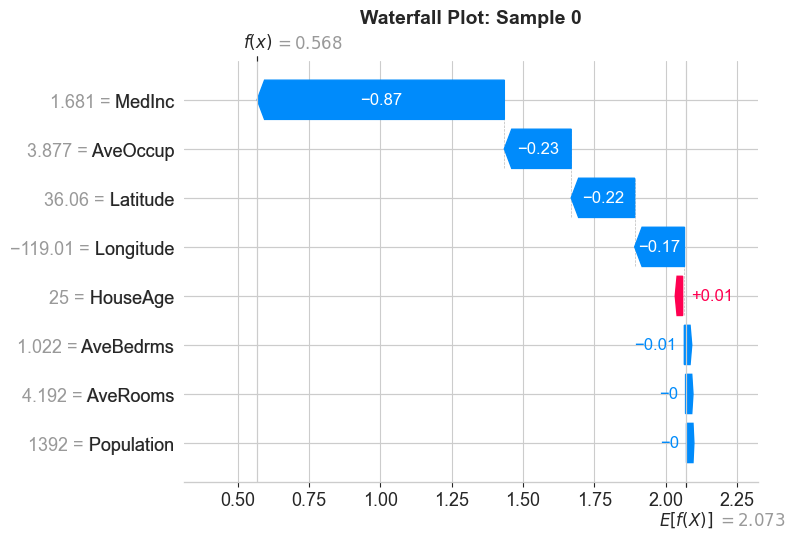

Interpretation:
- Start at E[f(X)] (expected value / baseline)
- Each bar shows feature contribution
- Red = positive contribution (increases prediction)
- Blue = negative contribution (decreases prediction)
- End at f(x) (final prediction)


In [23]:
# Create Explanation object for waterfall plot
explanation_reg = shap.Explanation(
    values=shap_values_reg[sample_idx],
    base_values=explainer_reg.expected_value,
    data=X_test_sample_reg.iloc[sample_idx].values,
    feature_names=X_test_sample_reg.columns.tolist()
)

# Waterfall plot
shap.plots.waterfall(explanation_reg, show=False)
plt.title(f'Waterfall Plot: Sample {sample_idx}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("Interpretation:")
print("- Start at E[f(X)] (expected value / baseline)")
print("- Each bar shows feature contribution")
print("- Red = positive contribution (increases prediction)")
print("- Blue = negative contribution (decreases prediction)")
print("- End at f(x) (final prediction)")

### 4.3 Decision Plot (Single Prediction)

The **decision plot** shows how the model reaches a prediction as features are added, from most to least important.

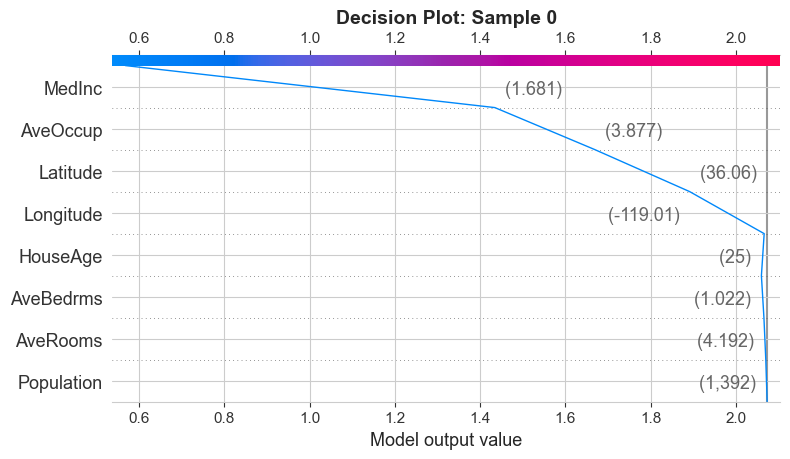

Interpretation:
- Y-axis: Features (ordered by importance)
- X-axis: Model output value
- Line shows cumulative effect as features are added
- Starts at base value, ends at prediction


In [24]:
# Decision plot for single sample
shap.decision_plot(
    base_value=explainer_reg.expected_value,
    shap_values=shap_values_reg[sample_idx],
    features=X_test_sample_reg.iloc[sample_idx],
    feature_names=X_test_sample_reg.columns.tolist(),
    show=False
)
plt.title(f'Decision Plot: Sample {sample_idx}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("Interpretation:")
print("- Y-axis: Features (ordered by importance)")
print("- X-axis: Model output value")
print("- Line shows cumulative effect as features are added")
print("- Starts at base value, ends at prediction")

### 4.4 Comparing Multiple Local Explanations

In [25]:
# Interactive force plot for multiple samples
# This creates an interactive visualization (works in Jupyter)
shap.force_plot(
    base_value=explainer_reg.expected_value,
    shap_values=shap_values_reg[:100],  # First 100 samples
    features=X_test_sample_reg.iloc[:100]
)

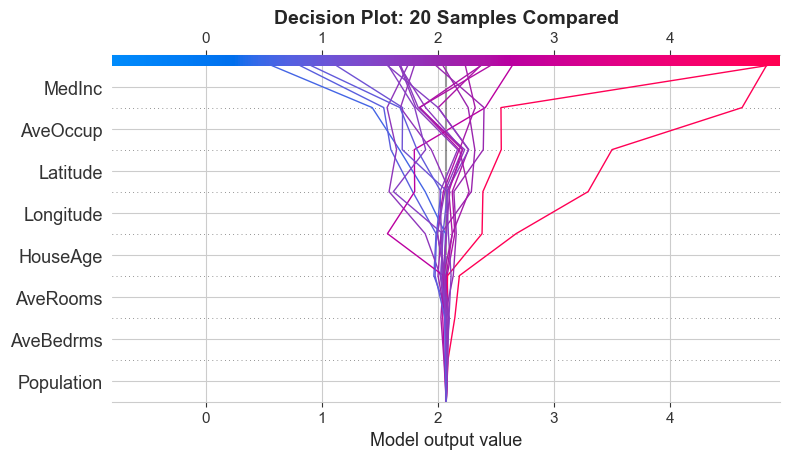

Interpretation:
- Each line is one sample's journey to prediction
- Lines spreading = features cause different predictions
- Lines converging = features have similar effects


In [26]:
# Decision plot for multiple samples
# Shows how different samples reach different predictions
shap.decision_plot(
    base_value=explainer_reg.expected_value,
    shap_values=shap_values_reg[:20],  # First 20 samples
    features=X_test_sample_reg.iloc[:20],
    feature_names=X_test_sample_reg.columns.tolist(),
    show=False
)
plt.title('Decision Plot: 20 Samples Compared', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("Interpretation:")
print("- Each line is one sample's journey to prediction")
print("- Lines spreading = features cause different predictions")
print("- Lines converging = features have similar effects")

---

## Part 5: Global Explanations for Regression

**Global explanations** explain the model's behavior overall.

**Question:** Which features are most important? How do features affect predictions in general?

---

### 5.1 Summary Plot (Bar) - Global Feature Importance

The **bar summary plot** shows average absolute SHAP values for each feature.

/var/folders/d9/9scbkz5n6dg0_zrw66xpqznc0000gq/T/ipykernel_68043/1093372518.py:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


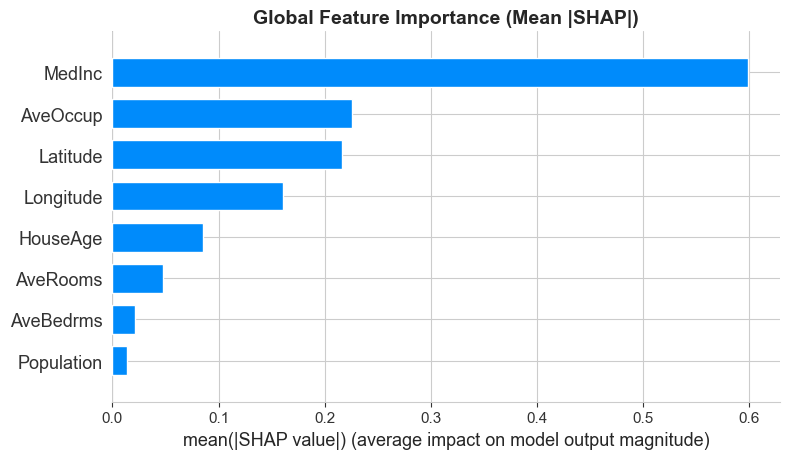

Interpretation:
- Bar length = average absolute SHAP value
- Longer bar = more important feature
- Features ranked from most to least important

This shows WHAT is important, not HOW it affects predictions.


In [27]:
# Bar summary plot - Global feature importance
shap.summary_plot(
    shap_values_reg,
    X_test_sample_reg,
    plot_type="bar",
    show=False
)
plt.title('Global Feature Importance (Mean |SHAP|)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("Interpretation:")
print("- Bar length = average absolute SHAP value")
print("- Longer bar = more important feature")
print("- Features ranked from most to least important")
print("\nThis shows WHAT is important, not HOW it affects predictions.")

### 5.2 Summary Plot (Beeswarm) - Feature Impact Distribution

The **beeswarm summary plot** shows how feature values affect predictions.

/var/folders/d9/9scbkz5n6dg0_zrw66xpqznc0000gq/T/ipykernel_68043/1051060334.py:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


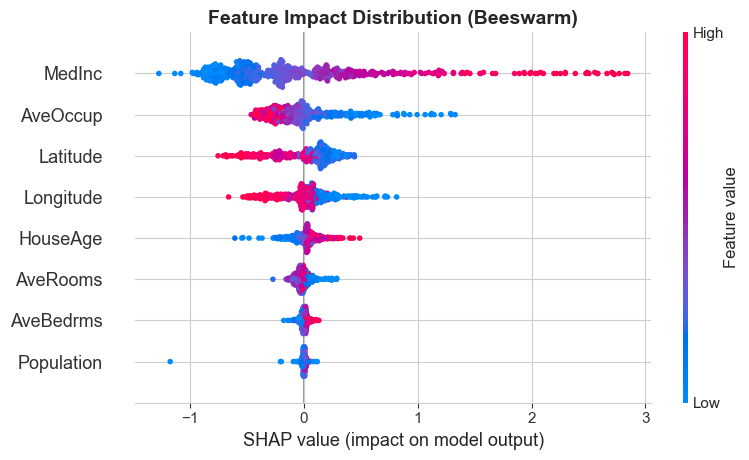

Interpretation:
- Each dot is one sample
- X-axis: SHAP value (impact on prediction)
- Color: Feature value (red=high, blue=low)
- Spread: Variability of feature's effect

Example insight:
- MedInc (top): High values (red) → high SHAP values (right)
  Meaning: Higher income → higher predicted house price


In [28]:
# Beeswarm summary plot - Shows distribution of SHAP values
shap.summary_plot(
    shap_values_reg,
    X_test_sample_reg,
    show=False
)
plt.title('Feature Impact Distribution (Beeswarm)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("Interpretation:")
print("- Each dot is one sample")
print("- X-axis: SHAP value (impact on prediction)")
print("- Color: Feature value (red=high, blue=low)")
print("- Spread: Variability of feature's effect")
print("\nExample insight:")
print("- MedInc (top): High values (red) → high SHAP values (right)")
print("  Meaning: Higher income → higher predicted house price")

### 5.4 Heatmap - SHAP Values for All Samples

The **heatmap** provides a global view of SHAP values across all samples.

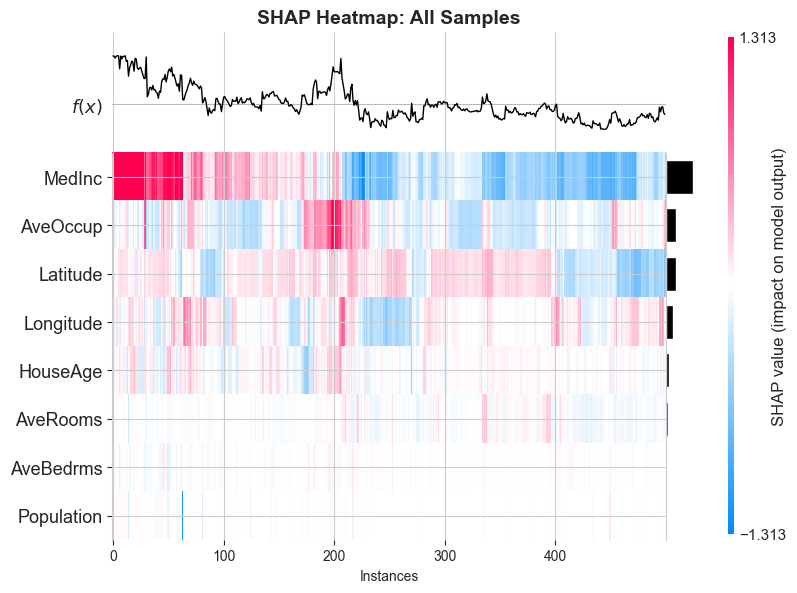

Interpretation:
- Each column is a sample
- Each row is a feature
- Color: SHAP value (red=positive, blue=negative)
- Shows patterns of feature effects across dataset


In [31]:
# Create Explanation object for heatmap
explanation_all_reg = shap.Explanation(
    values=shap_values_reg,
    base_values=np.full(len(shap_values_reg), explainer_reg.expected_value),
    data=X_test_sample_reg.values,
    feature_names=X_test_sample_reg.columns.tolist()
)

# Heatmap
shap.plots.heatmap(explanation_all_reg, show=False)
plt.title('SHAP Heatmap: All Samples', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("Interpretation:")
print("- Each column is a sample")
print("- Each row is a feature")
print("- Color: SHAP value (red=positive, blue=negative)")
print("- Shows patterns of feature effects across dataset")

### 5.5 SHAP Interaction Values

**Interaction values** show how features interact with each other.

In [32]:
# Calculate interaction values (computationally expensive - use small sample)
print("Calculating SHAP interaction values (this may take a minute)...")

# Use smaller sample for interaction values
X_interaction_sample = X_test_sample_reg.iloc[:100]
shap_interaction_values = explainer_reg.shap_interaction_values(X_interaction_sample)

print(f"✓ Interaction values calculated!")
print(f"Shape: {shap_interaction_values.shape}")
print(f"(samples, features, features)")

Calculating SHAP interaction values (this may take a minute)...
✓ Interaction values calculated!
Shape: (100, 8, 8)
(samples, features, features)


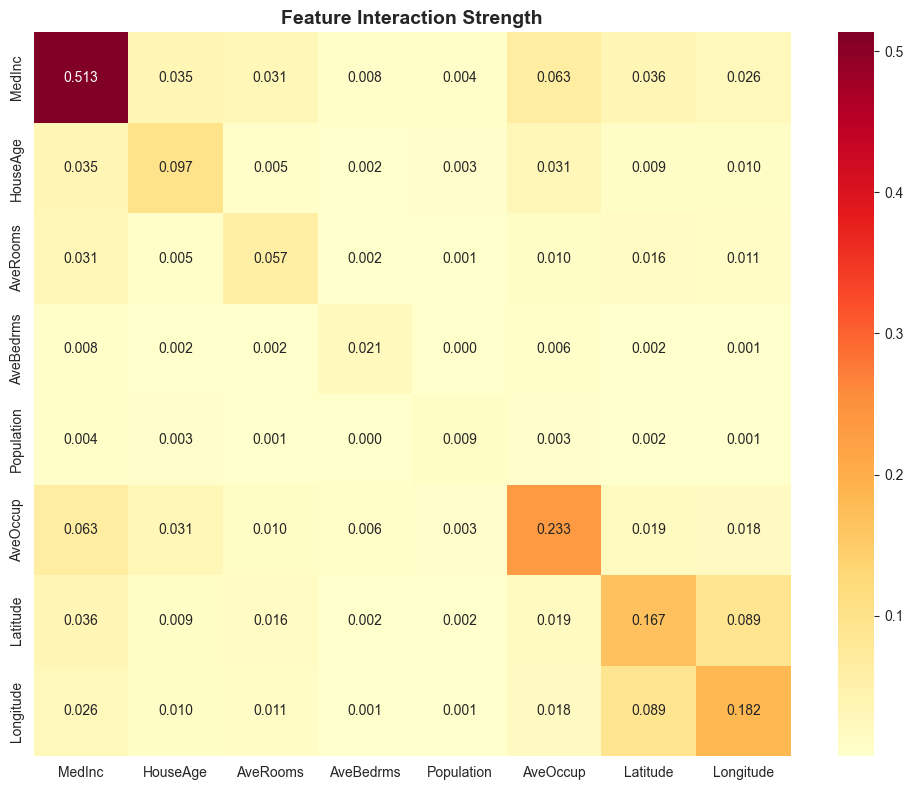

Interpretation:
- Diagonal: Main effects (individual feature importance)
- Off-diagonal: Interaction effects between features
- Higher value = stronger interaction


In [33]:
# Interaction summary - average absolute interaction
# Create interaction matrix
mean_interactions = np.abs(shap_interaction_values).mean(axis=0)

plt.figure(figsize=(10, 8))
sns.heatmap(
    mean_interactions,
    xticklabels=X_test_sample_reg.columns,
    yticklabels=X_test_sample_reg.columns,
    annot=True,
    fmt='.3f',
    cmap='YlOrRd'
)
plt.title('Feature Interaction Strength', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("Interpretation:")
print("- Diagonal: Main effects (individual feature importance)")
print("- Off-diagonal: Interaction effects between features")
print("- Higher value = stronger interaction")

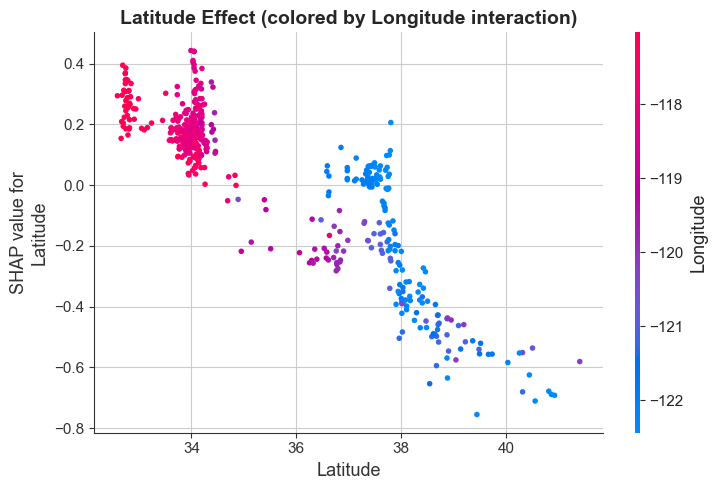

This shows how Latitude's effect depends on Longitude value!
(Geographic location interaction in California housing)


In [34]:
# Dependence plot with interaction coloring
shap.dependence_plot(
    "Latitude",
    shap_values_reg,
    X_test_sample_reg,
    interaction_index="Longitude",  # Specify interaction feature
    show=False
)
plt.title('Latitude Effect (colored by Longitude interaction)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("This shows how Latitude's effect depends on Longitude value!")
print("(Geographic location interaction in California housing)")

---

# SECTION B: SHAP for Classification

---

## Part 6: Classification Example - Breast Cancer

We'll predict whether a tumor is malignant or benign.

### 6.1 Load and Prepare Data

In [70]:
# Load Breast Cancer dataset
cancer = load_breast_cancer()
X_cancer = pd.DataFrame(cancer.data, columns=cancer.feature_names)
y_cancer = cancer.target  # 0 = malignant, 1 = benign

print("=== Breast Cancer Dataset ===")
print(f"Samples: {len(X_cancer)}")
print(f"Features: {len(X_cancer.columns)}")
print(f"\nClass distribution:")
print(f"  Malignant (0): {(y_cancer == 0).sum()} ({(y_cancer == 0).mean():.1%})")
print(f"  Benign (1): {(y_cancer == 1).sum()} ({(y_cancer == 1).mean():.1%})")
print(f"\nFeature examples:")
print(f"  - mean radius, mean texture, mean perimeter, ...")
print(f"  - worst radius, worst texture, worst perimeter, ...")

=== Breast Cancer Dataset ===
Samples: 569
Features: 30

Class distribution:
  Malignant (0): 212 (37.3%)
  Benign (1): 357 (62.7%)

Feature examples:
  - mean radius, mean texture, mean perimeter, ...
  - worst radius, worst texture, worst perimeter, ...


In [71]:
# Train-test split
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_cancer, y_cancer, test_size=0.2, random_state=42, stratify=y_cancer
)

print(f"Training samples: {len(X_train_clf)}")
print(f"Test samples: {len(X_test_clf)}")

Training samples: 455
Test samples: 114


In [72]:
print("Number of Features: ", len(X_train_clf.keys()))

Number of Features:  30


### 6.2 Train Classification Model

In [73]:
# Train a Random Forest Classifier
clf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

clf_model.fit(X_train_clf, y_train_clf)

# Evaluate
y_pred_clf = clf_model.predict(X_test_clf)
accuracy = accuracy_score(y_test_clf, y_pred_clf)

print("=== Classification Model Performance ===")
print(f"Model: Random Forest Classifier")
print(f"Accuracy: {accuracy:.3f}")
print("\n✓ Model trained successfully!")

=== Classification Model Performance ===
Model: Random Forest Classifier
Accuracy: 0.956

✓ Model trained successfully!


### 6.3 Create SHAP Explainer for Classification

**Important for Classification:**
- SHAP values are calculated for each class separately
- For binary classification, we typically focus on one class (positive class)
- SHAP values represent contribution to the probability/log-odds

In [74]:
# Create SHAP explainer
explainer_clf = shap.TreeExplainer(clf_model)

# Calculate SHAP values
print("Calculating SHAP values for classification model...")
shap_values_raw = explainer_clf.shap_values(X_test_clf)

# Handle different SHAP output formats (varies by version)
# Newer SHAP versions return 3D array (samples, features, classes)
# Older versions return list of 2D arrays [class_0, class_1]
if isinstance(shap_values_raw, np.ndarray) and shap_values_raw.ndim == 3:
    # New format: (samples, features, classes) -> convert to list of (samples, features)
    print("(Detected new SHAP format - converting...)")
    shap_values_clf = [shap_values_raw[:, :, i] for i in range(shap_values_raw.shape[2])]
else:
    # Old format: already a list
    shap_values_clf = shap_values_raw

print(f"\n✓ SHAP values calculated!")
print(f"Number of classes: {len(shap_values_clf)}")
print(f"Shape per class: {shap_values_clf[0].shape}")
print(f"\nExpected values (baseline probabilities):")
print(f"  Malignant (class 0): {explainer_clf.expected_value[0]:.3f}")
print(f"  Benign (class 1): {explainer_clf.expected_value[1]:.3f}")

Calculating SHAP values for classification model...
(Detected new SHAP format - converting...)

✓ SHAP values calculated!
Number of classes: 2
Shape per class: (114, 30)

Expected values (baseline probabilities):
  Malignant (class 0): 0.376
  Benign (class 1): 0.624


---

## Part 7: Local Explanations for Classification

**Question:** Why was THIS patient classified as malignant/benign?

---

### 7.1 Force Plot for Classification

In [75]:
# Select a sample to explain
sample_idx = 0

# Get prediction (use DataFrame slice to preserve feature names and avoid warning)
sample_clf = X_test_clf.iloc[[sample_idx]]  # DataFrame with 1 row
prediction_clf = clf_model.predict(sample_clf)[0]
proba_clf = clf_model.predict_proba(sample_clf)[0]
actual_clf = y_test_clf.iloc[sample_idx] if hasattr(y_test_clf, 'iloc') else y_test_clf[sample_idx]

class_names = ['Malignant', 'Benign']

print(f"=== Sample {sample_idx} ===")
print(f"\nActual: {class_names[actual_clf]}")
print(f"Predicted: {class_names[prediction_clf]}")
print(f"Probability (Benign): {proba_clf[1]:.3f}")
print(f"Probability (Malignant): {proba_clf[0]:.3f}")

=== Sample 0 ===

Actual: Malignant
Predicted: Malignant
Probability (Benign): 0.000
Probability (Malignant): 1.000


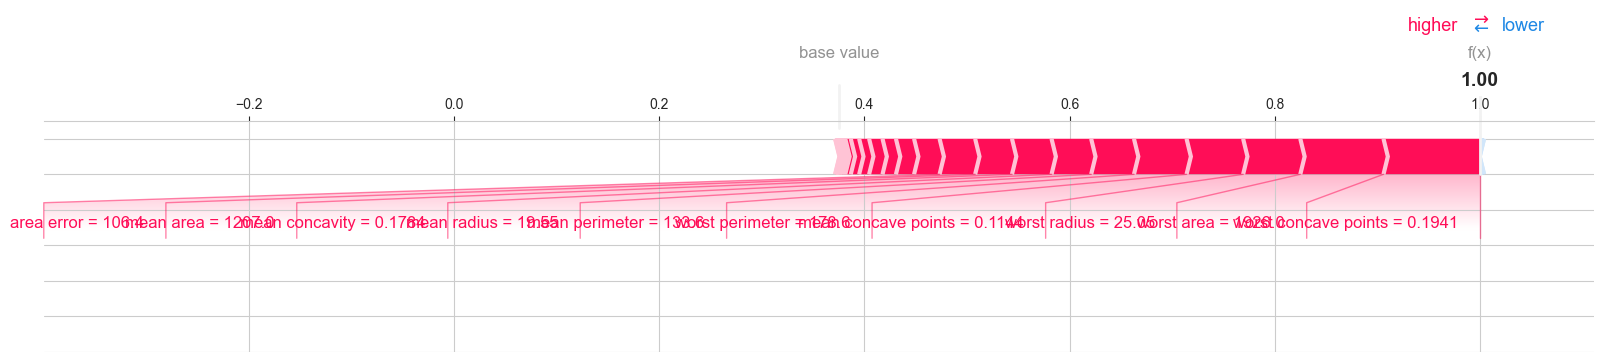

In [76]:
fig = plt.figure(figsize=(10, 2))
shap.force_plot(
    base_value=explainer_clf.expected_value[0],  # Benign class
    shap_values=shap_values_clf[0][sample_idx],  # Benign class SHAP values (1D)
    features=X_test_clf.iloc[sample_idx].values,  # 1D array matching SHAP values
    feature_names=X_test_clf.columns.tolist(),    # List of feature names
    matplotlib=True,
    show=False
)

<Figure size 1000x200 with 0 Axes>

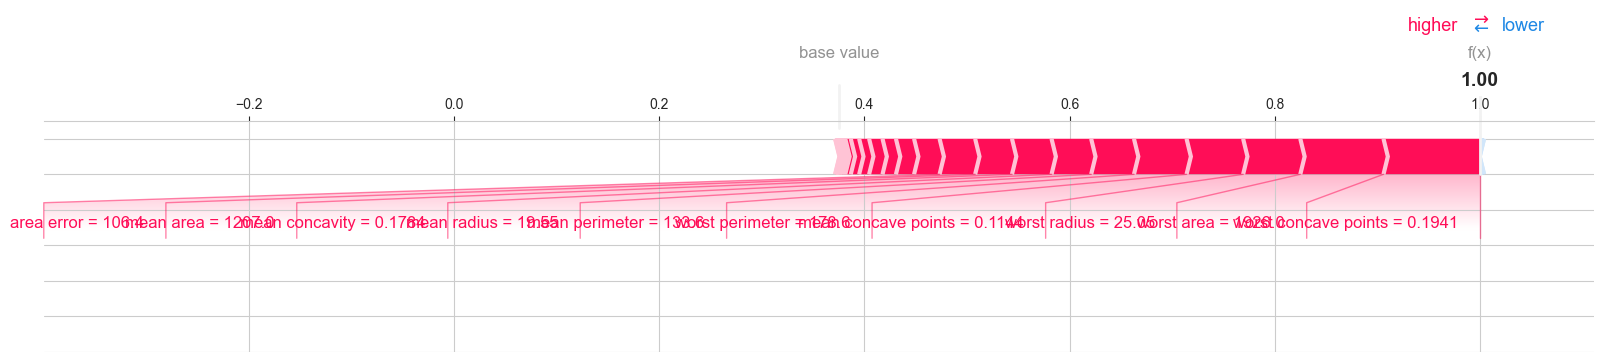

<Figure size 1000x200 with 0 Axes>

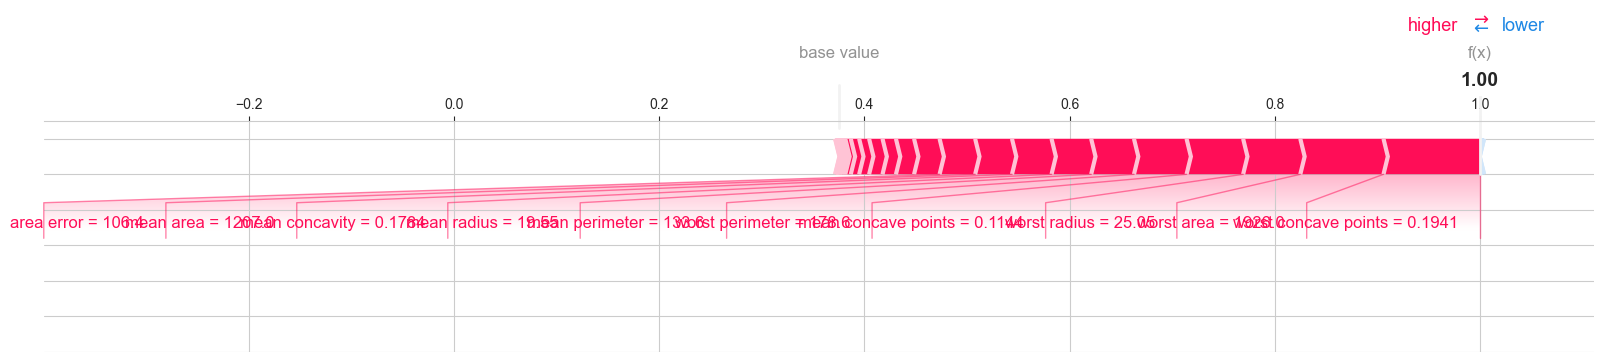

<Figure size 1000x200 with 0 Axes>

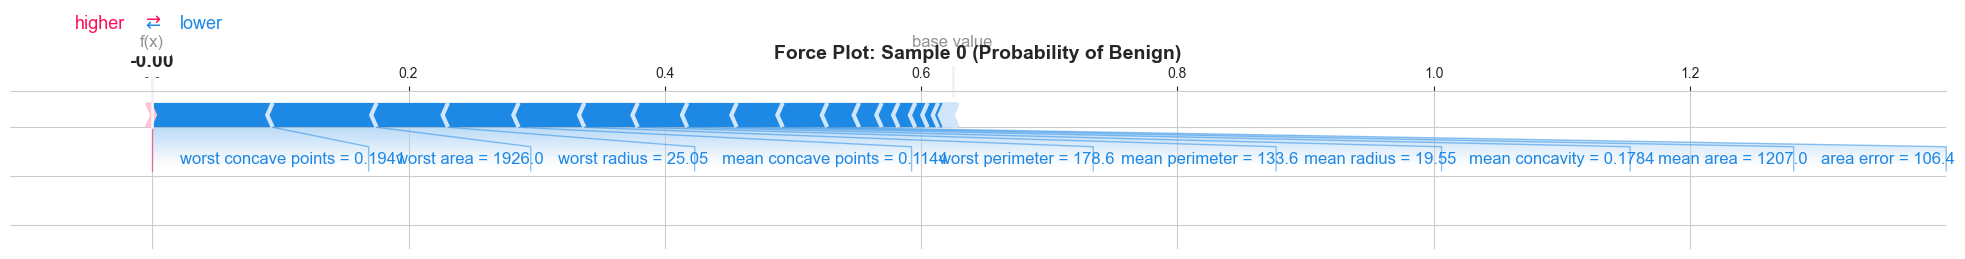

Interpretation:
- Red features: Push towards Benign (positive class)
- Blue features: Push towards Malignant (negative class)
- Base value: Average probability of being Benign
- Final value: This sample's probability of being Benign


In [77]:
# Force plot for classification (for positive class = Benign)
# Fix: Pass features as a 1D array (values) and feature_names separately to match shap_values length.

fig = plt.figure(figsize=(10, 2))
shap.force_plot(
    base_value=explainer_clf.expected_value[1],  # Benign class
    shap_values=shap_values_clf[1][sample_idx],  # Benign class SHAP values (1D)
    features=X_test_clf.iloc[sample_idx].values,  # 1D array matching SHAP values
    feature_names=X_test_clf.columns.tolist(),    # List of feature names
    matplotlib=True,
    show=False
)
plt.title(f'Force Plot: Sample {sample_idx} (Probability of Benign)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("Interpretation:")
print("- Red features: Push towards Benign (positive class)")
print("- Blue features: Push towards Malignant (negative class)")
print("- Base value: Average probability of being Benign")
print("- Final value: This sample's probability of being Benign")

### 7.2 Waterfall Plot for Classification

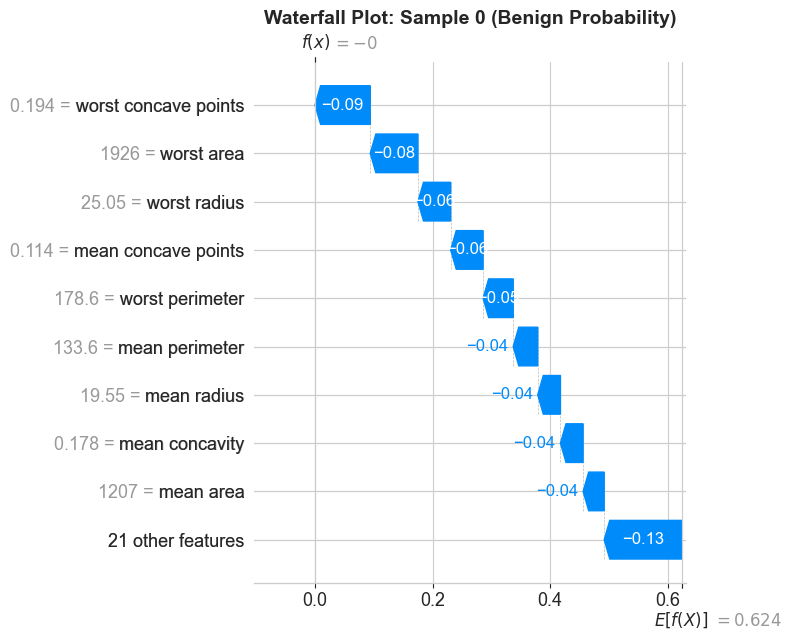

In [78]:
# Waterfall plot for classification
explanation_clf = shap.Explanation(
    values=shap_values_clf[1][sample_idx],  # Benign class
    base_values=explainer_clf.expected_value[1],
    data=X_test_clf.iloc[sample_idx].values,
    feature_names=X_test_clf.columns.tolist()
)

shap.plots.waterfall(explanation_clf, show=False)
plt.title(f'Waterfall Plot: Sample {sample_idx} (Benign Probability)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

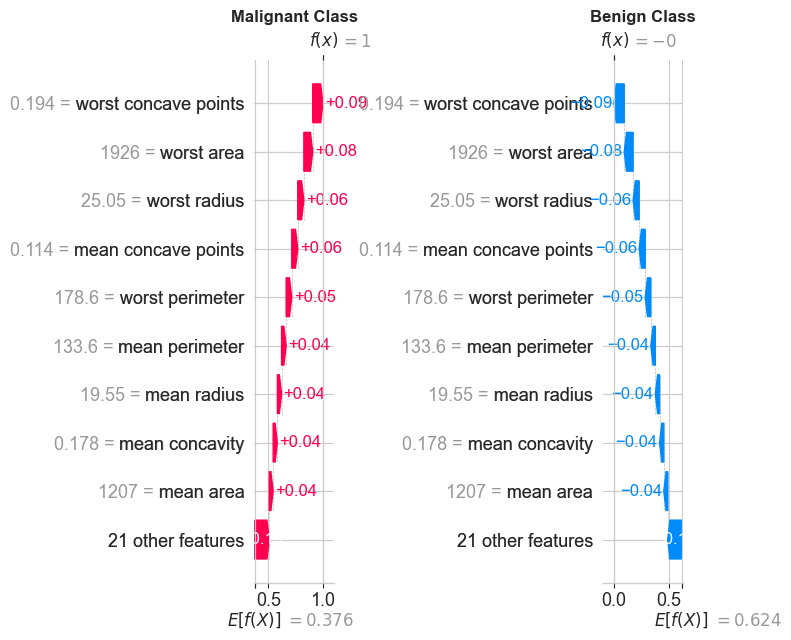

Note: SHAP values for the two classes are symmetric (sum to 0)
Features pushing towards Benign push away from Malignant, and vice versa.


In [79]:
# Compare Malignant vs Benign explanations for same sample
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for class_idx, class_name in enumerate(class_names):
    explanation = shap.Explanation(
        values=shap_values_clf[class_idx][sample_idx],
        base_values=explainer_clf.expected_value[class_idx],
        data=X_test_clf.iloc[sample_idx].values,
        feature_names=X_test_clf.columns.tolist()
    )
    plt.sca(axes[class_idx])
    shap.plots.waterfall(explanation, show=False, max_display=10)
    axes[class_idx].set_title(f'{class_name} Class', fontweight='bold')

plt.tight_layout()
plt.show()

print("Note: SHAP values for the two classes are symmetric (sum to 0)")
print("Features pushing towards Benign push away from Malignant, and vice versa.")

### 7.3 Decision Plot for Classification

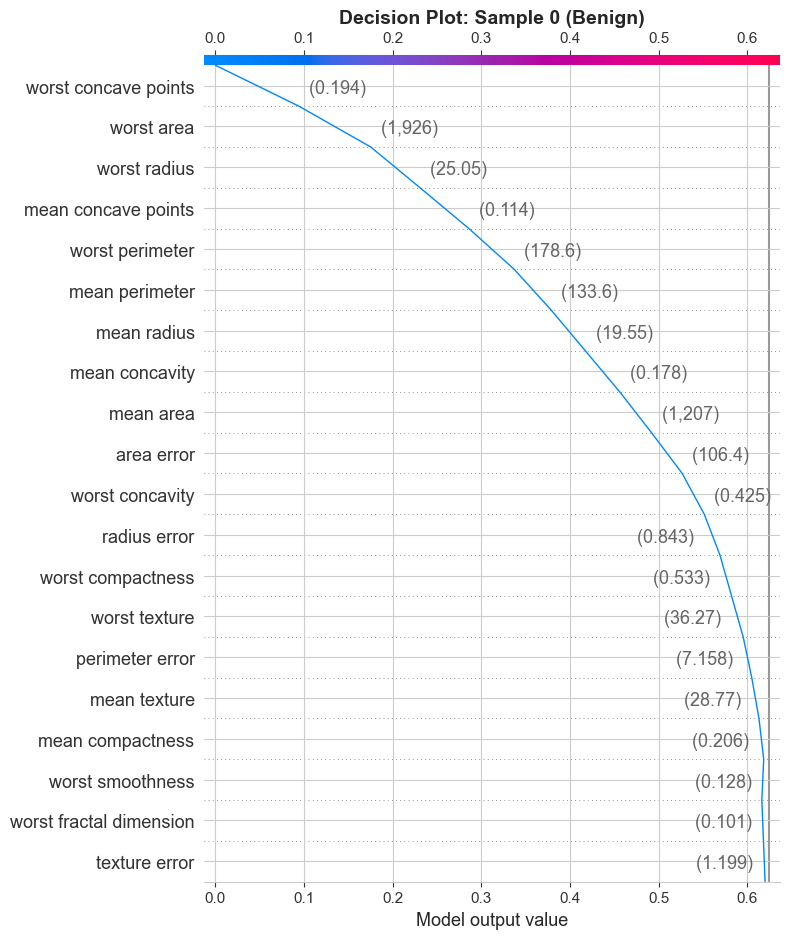

In [80]:
# Decision plot for single sample (Benign class)
shap.decision_plot(
    base_value=explainer_clf.expected_value[1],
    shap_values=shap_values_clf[1][sample_idx],
    features=X_test_clf.iloc[sample_idx],
    feature_names=X_test_clf.columns.tolist(),
    show=False
)
plt.title(f'Decision Plot: Sample {sample_idx} (Benign)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 7.4 Explaining Misclassified Samples

SHAP is especially useful for understanding model errors!

Misclassified samples: 5 out of 114

=== Analyzing Misclassified Sample 3 ===
Actual: Benign
Predicted: Malignant
Probability (Benign): 0.280


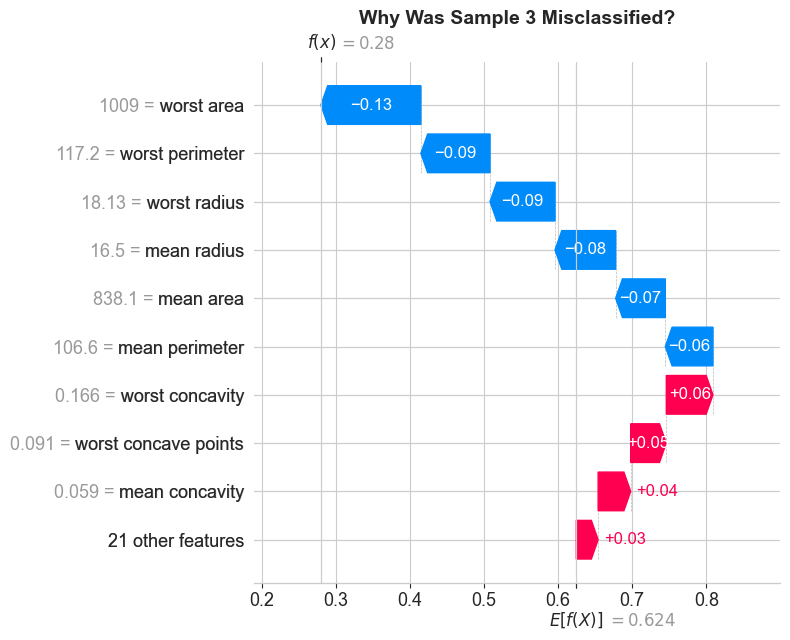


This shows which features led to the wrong prediction!


In [87]:
# Find misclassified samples
misclassified = np.where(y_pred_clf != y_test_clf)[0]

print(f"Misclassified samples: {len(misclassified)} out of {len(y_test_clf)}")

if len(misclassified) > 0:
    # Explain first misclassified sample
    error_idx = misclassified[0]
    
    # Use DataFrame slice to preserve feature names
    error_sample = X_test_clf.iloc[[error_idx]]
    
    print(f"\n=== Analyzing Misclassified Sample {error_idx} ===")
    print(f"Actual: {class_names[y_test_clf[error_idx]]}")
    print(f"Predicted: {class_names[y_pred_clf[error_idx]]}")
    print(f"Probability (Benign): {clf_model.predict_proba(error_sample)[0][1]:.3f}")
    
    # Waterfall for misclassified
    explanation_error = shap.Explanation(
        values=shap_values_clf[1][error_idx],
        base_values=explainer_clf.expected_value[1],
        data=X_test_clf.iloc[error_idx].values,
        feature_names=X_test_clf.columns.tolist()
    )
    
    shap.plots.waterfall(explanation_error, show=False, max_display=10)
    plt.title(f'Why Was Sample {error_idx} Misclassified?', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print("\nThis shows which features led to the wrong prediction!")
else:
    print("No misclassified samples - model is very accurate!")

The Problem: This patient had a large tumor (high area, radius, perimeter) but low concavity (smooth shape). The model focused too much on the size and predicted Malignant, but the tumor was actually Benign despite being large.



---

## Part 8: Global Explanations for Classification

**Question:** Which features are most important for distinguishing malignant from benign tumors?

---

### 8.1 Summary Plot (Bar) - Global Feature Importance

/var/folders/d9/9scbkz5n6dg0_zrw66xpqznc0000gq/T/ipykernel_68043/2447529140.py:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


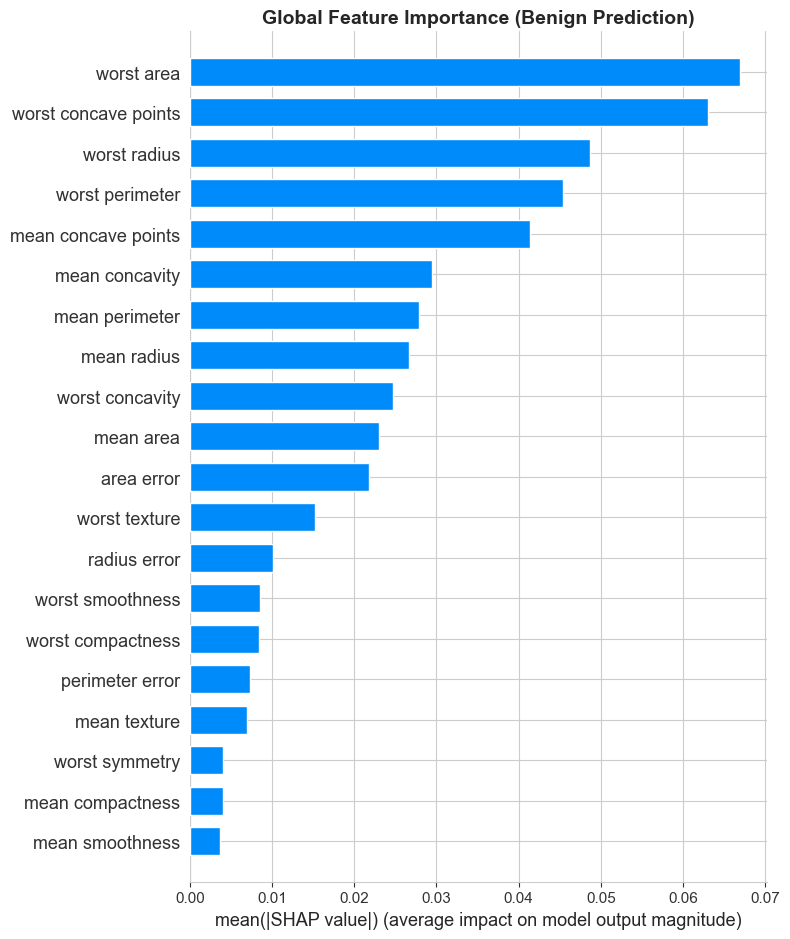

In [82]:
# Global feature importance (for Benign class)
shap.summary_plot(
    shap_values_clf[1],  # Benign class
    X_test_clf,
    plot_type="bar",
    show=False
)
plt.title('Global Feature Importance (Benign Prediction)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

/var/folders/d9/9scbkz5n6dg0_zrw66xpqznc0000gq/T/ipykernel_68043/2870687576.py:6: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(
/var/folders/d9/9scbkz5n6dg0_zrw66xpqznc0000gq/T/ipykernel_68043/2870687576.py:6: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


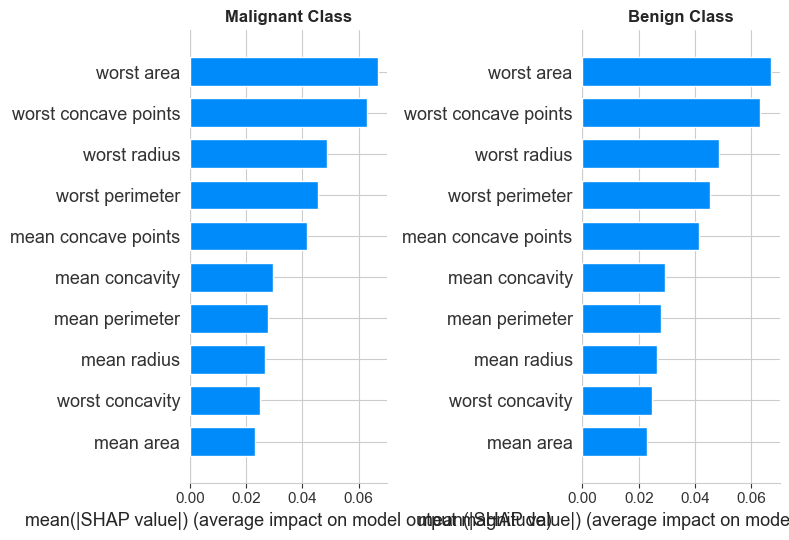

Note: Feature importance is the same for both classes (symmetric).
The direction of effect (positive/negative) differs.


In [83]:
# Compare feature importance for both classes
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for class_idx, class_name in enumerate(class_names):
    plt.sca(axes[class_idx])
    shap.summary_plot(
        shap_values_clf[class_idx],
        X_test_clf,
        plot_type="bar",
        show=False,
        max_display=10
    )
    axes[class_idx].set_title(f'{class_name} Class', fontweight='bold')

plt.tight_layout()
plt.show()

print("Note: Feature importance is the same for both classes (symmetric).")
print("The direction of effect (positive/negative) differs.")

---

## Part 9: Summary of All SHAP Plots

---

### SHAP Plot Reference Guide

| Plot | Scope | Purpose | When to Use |
|------|-------|---------|-------------|
| **Force Plot** | Local | Show feature contributions for single prediction | Explaining individual predictions to stakeholders |
| **Waterfall Plot** | Local | Step-by-step view of single prediction | Detailed analysis of one sample |
| **Decision Plot** | Local/Global | Show path from base to prediction | Compare multiple predictions, spot outliers |
| **Bar Summary** | Global | Show mean absolute SHAP values | Quick overview of feature importance |
| **Beeswarm** | Global | Show SHAP value distribution | Understand how feature VALUES affect predictions |
| **Dependence Plot** | Global | Show feature-output relationship | Deep dive into single feature's effect |
| **Heatmap** | Global | Overview of all SHAP values | Pattern discovery across dataset |
| **Interaction Plot** | Global | Show feature interactions | Understanding feature combinations |

---

### Local vs Global Summary

**LOCAL EXPLANATIONS:**
- Answer: "Why this prediction?"
- Scope: Single sample
- Plots: Force, Waterfall, Decision (single line)
- Use case: Debugging, stakeholder communication, model audit

**GLOBAL EXPLANATIONS:**
- Answer: "What does the model learn?"
- Scope: All samples / model behavior
- Plots: Bar Summary, Beeswarm, Dependence, Heatmap
- Use case: Model understanding, feature selection, documentation

---

## Part 10: SHAP with Different Explainers

SHAP provides different explainers optimized for different model types.

=== LinearExplainer Demo ===
Linear model accuracy: 0.974
SHAP values shape: (100, 30)


/Users/sschacht/anaconda3/envs/dspy/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/var/folders/d9/9scbkz5n6dg0_zrw66xpqznc0000gq/T/ipykernel_68043/1279643148.py:16: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(lin_shap_values, X_test_clf[:100], plot_type="bar", show=Fals

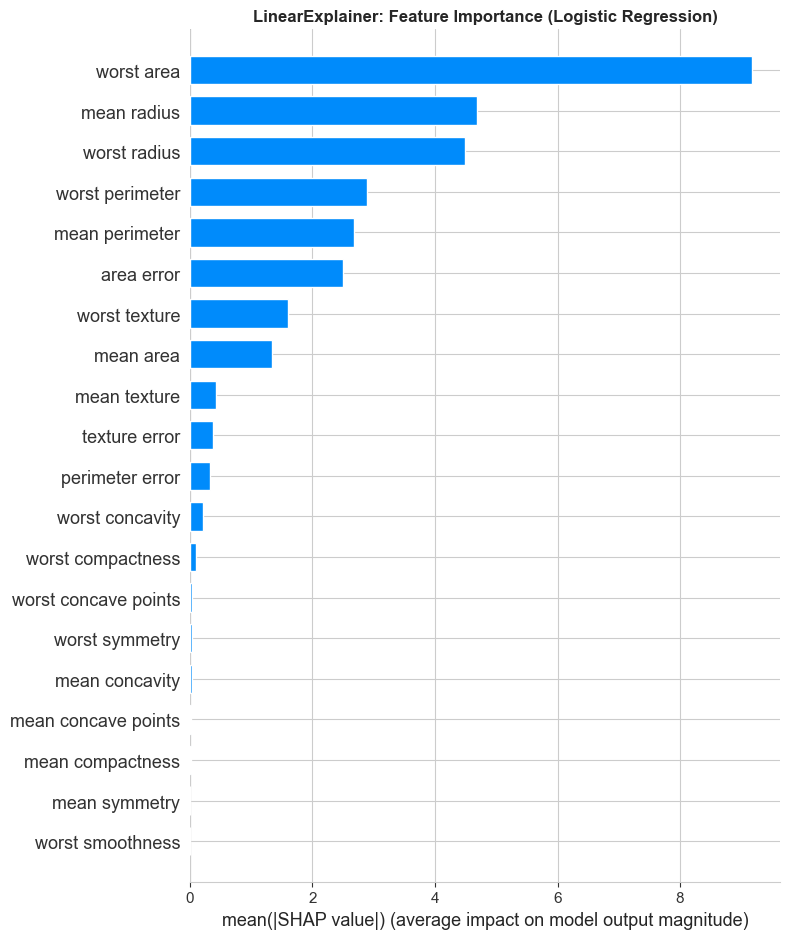

In [85]:
# 1. LinearExplainer - For linear models
print("=== LinearExplainer Demo ===")

# Train linear model
lin_model = LogisticRegression(max_iter=1000, random_state=42)
lin_model.fit(X_train_clf, y_train_clf)

# Create linear explainer
lin_explainer = shap.LinearExplainer(lin_model, X_train_clf)
lin_shap_values = lin_explainer.shap_values(X_test_clf[:100])

print(f"Linear model accuracy: {lin_model.score(X_test_clf, y_test_clf):.3f}")
print(f"SHAP values shape: {lin_shap_values.shape}")

# Quick summary
shap.summary_plot(lin_shap_values, X_test_clf[:100], plot_type="bar", show=False)
plt.title('LinearExplainer: Feature Importance (Logistic Regression)', fontweight='bold')
plt.tight_layout()
plt.show()

In [86]:
# 2. KernelExplainer - Model agnostic (works with ANY model)
print("=== KernelExplainer Demo ===")
print("(This is slower but works with any model)")

# Use small background sample for speed
background = shap.sample(X_train_clf, 50)

# Create kernel explainer
kernel_explainer = shap.KernelExplainer(clf_model.predict_proba, background)

# Calculate for small sample (slow!)
print("Calculating SHAP values (this takes a moment)...")
kernel_shap_values = kernel_explainer.shap_values(X_test_clf.iloc[:10])

print(f"✓ KernelExplainer SHAP values calculated!")
print(f"Shape: {np.array(kernel_shap_values).shape}")

# Compare to TreeExplainer
print("\nKernelExplainer is model-agnostic but slower.")
print("Use TreeExplainer for tree models, LinearExplainer for linear models.")

=== KernelExplainer Demo ===
(This is slower but works with any model)
Calculating SHAP values (this takes a moment)...


100%|██████████| 10/10 [00:00<00:00, 11.72it/s]

✓ KernelExplainer SHAP values calculated!
Shape: (10, 30, 2)

KernelExplainer is model-agnostic but slower.
Use TreeExplainer for tree models, LinearExplainer for linear models.


---

## Part 11: Practical Guidelines

---

### When to Use Which SHAP Explainer

| Model Type | Explainer | Speed |
|------------|-----------|-------|
| Random Forest, XGBoost, LightGBM, CatBoost | `TreeExplainer` | Fast |
| Linear Regression, Logistic Regression | `LinearExplainer` | Fast |
| Deep Neural Networks (PyTorch/TensorFlow) | `DeepExplainer` | Medium |
| Any model (model-agnostic) | `KernelExplainer` | Slow |
| Auto-select | `Explainer` | Varies |

### Best Practices

**DO ✓**
- Use appropriate explainer for your model type
- Sample data for large datasets (speed)
- Validate SHAP values sum to prediction - baseline
- Use multiple plot types for comprehensive understanding
- Compare global and local explanations

**DON'T ✗**
- Use KernelExplainer for tree models (use TreeExplainer instead!)
- Trust SHAP blindly (it's an approximation)
- Interpret SHAP as causal (it's correlation!)
- Forget to set random seed for reproducibility

### Common Pitfalls

1. **Confusing SHAP with causation**
   - SHAP shows correlation, not causation
   - Feature importance ≠ causal effect

2. **Ignoring feature interactions**
   - Check interaction values for complex models
   - Dependence plots show interactions via color

3. **Over-interpreting small differences**
   - Small SHAP values may be noise
   - Focus on major contributors

4. **Forgetting the baseline**
   - SHAP values are relative to expected value
   - Always consider the baseline (average prediction)

---

## Summary

### What You Learned

1. ✓ **Mathematical foundation:** Shapley values from game theory
2. ✓ **SHAP for regression:** California housing price prediction
3. ✓ **SHAP for classification:** Breast cancer diagnosis
4. ✓ **Local explanations:** Force, Waterfall, Decision plots
5. ✓ **Global explanations:** Bar Summary, Beeswarm, Dependence, Heatmap
6. ✓ **Interaction values:** Understanding feature interactions
7. ✓ **Different explainers:** TreeExplainer, LinearExplainer, KernelExplainer

### Key Takeaways

- SHAP provides theoretically grounded explanations
- Local explanations: "Why this prediction?"
- Global explanations: "What did the model learn?"
- Choose the right explainer for your model type
- SHAP is correlation, not causation!

### Next Steps

- Apply SHAP to your own models
- Combine with fairness analysis (explain predictions for different groups)
- Use for model debugging and improvement
- Include SHAP plots in Model Cards

---

**SHAP is one of the most powerful tools for explainable AI. Master it and you'll be able to explain any model!**

**Happy explaining!** 🎯

---

## Part 12: Practical Applications of SHAP

### Beyond Basic Explanations: Three Powerful Use Cases

SHAP is not just for understanding models - it's a versatile tool that can be applied throughout the machine learning lifecycle. Here are three critical applications:

---

### 🔍 1. Model Error Debugging (Wrong Predictions)

**Use Case:** Your model makes a wrong prediction. Why?

SHAP helps you understand **why** the model made a mistake:

**Workflow:**
1. Identify misclassified/high-error samples
2. Generate SHAP explanations for these samples
3. Compare to correctly predicted samples
4. Identify features that "fooled" the model

**What to look for:**
- **Outlier feature values:** Was an unusual feature value responsible?
- **Feature interactions:** Did a combination of features cause the error?
- **Edge cases:** Is this sample at a decision boundary?
- **Data quality issues:** Possible mislabeling or data errors?

**Example applications:**
- Medical diagnosis errors (why was this cancer missed?)
- Fraud detection false positives (why was this legitimate transaction flagged?)
- Credit scoring rejections (why was this good customer rejected?)

```python
# Debugging workflow example:
# 1. Find errors
errors = X_test[y_pred != y_test]
# 2. Get SHAP values for errors
shap_errors = explainer.shap_values(errors)
# 3. Compare to correct predictions via decision plots
# 4. Identify problematic features
```

---

### 📊 2. Data Exploration and Feature Engineering

**Use Case:** Understand your data through the lens of model predictions.

SHAP reveals patterns in your data that correlations and histograms might miss:

**Workflow:**
1. Train a model on your data
2. Calculate SHAP values
3. Use summary and dependence plots to discover patterns
4. Inform feature engineering decisions

**What you can discover:**
- **Non-linear relationships:** Dependence plots show if effects are linear or curved
- **Interaction effects:** Color coding reveals how features interact
- **Feature redundancy:** Highly correlated SHAP values suggest redundancy
- **Data segments:** Clusters in SHAP space may reveal subpopulations

**Example insights:**
- "Income has a strong positive effect, but only above $50k - consider binning"
- "Age and experience interact - create a seniority feature"
- "These 3 features always move together - maybe combine them"
- "Two distinct clusters in SHAP space - different customer segments?"

**Benefits:**
- Data-driven feature engineering
- Hypothesis generation from model behavior
- Understanding domain through ML lens
- Identifying data quality issues (e.g., unexpected relationships)

---

### 📝 3. Model Documentation and Stakeholder Communication

**Use Case:** Explain your model to business stakeholders, regulators, or customers.

SHAP provides interpretable, visual explanations that non-technical audiences can understand:

**For Different Audiences:**

| Audience | Best SHAP Output |
|----------|------------------|
| **C-Suite / Business** | Bar summary plot (top 5-10 features) |
| **Regulators** | Individual force/waterfall plots + documentation |
| **Data Scientists** | Full suite: beeswarm, dependence, interactions |
| **Customers** | Simple waterfall showing "why this decision" |
| **Model Cards** | Global importance + sample local explanations |

**Use Cases:**
- **Model Cards:** Include SHAP plots as standard documentation
- **Fairness Audits:** Compare SHAP values across demographic groups
- **Regulatory Compliance:** GDPR "right to explanation", fair lending laws
- **Customer Trust:** "Here's why we made this recommendation"

**Documentation Best Practices:**
1. Always include baseline (expected value) context
2. Show both global (model behavior) and local (individual) explanations
3. Explain in domain terms, not just feature names
4. Acknowledge limitations (correlation ≠ causation)

---

### Summary: When to Use SHAP

| Situation | SHAP Application |
|-----------|------------------|
| Model makes unexpected predictions | **Error Debugging:** Compare misclassified vs. correct |
| Need to improve model | **Feature Engineering:** Discover non-linear effects, interactions |
| Need to understand data | **Data Exploration:** Use model as lens into data patterns |
| Need to explain to stakeholders | **Documentation:** Visual, intuitive explanations |
| Fairness concerns | **Bias Analysis:** Compare SHAP across groups |
| Regulatory requirements | **Compliance:** Individual decision explanations |

---

### Final Thoughts

**SHAP transforms "black-box" models into transparent, debuggable, understandable systems.**

Whether you're:
- 🐛 **Debugging** why a prediction went wrong
- 🔬 **Exploring** patterns in your data
- 📋 **Documenting** your model for stakeholders
- ⚖️ **Auditing** for fairness

SHAP provides a theoretically grounded, visually intuitive toolkit.

**Remember:** 
- Use local explanations for individual decisions
- Use global explanations for model understanding
- Combine both for comprehensive analysis
- Always interpret in domain context!

**Master SHAP, and you master explainable AI.** 🎯